In [1]:
from torch import nn
import jieba
import numpy as np
import re
import collections
import torch
from torch.nn import functional as F
import math
import random
import time
from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

# 通用module， timer， animator， accumulator

In [2]:
class Timer: #@save
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()
    
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
    
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# nlp vocab与读文件的函数

In [3]:
def read_chinese_file(path):
    """Load the chinese file into a list of text lines."""
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    return [re.sub('\s', ' ', line).strip() for line in lines]


def tokenize(lines):
    """根据jieba分词将lines分成tokens"""
    return [jieba.lcut(line) for line in lines]


def count_corpus(tokens):
    """count the frequency of token"""
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


class Vocab:
    """Vocabulary for text"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(),
                                   key=lambda x: x[1],
                                   reverse=True)
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {
            token: idx
            for idx, token in enumerate(self.idx_to_token)
        }
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.token_to_idx)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            # get 方法，先找第一个字符，找不到再找第二个字符
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs

# data_loader

In [4]:
def seq_data_iter_random(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using random sampling.

    Defined in :numref:`sec_language_model`"""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos:pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)


def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using sequtial partitioning """
    offset = random.randint(0, num_steps)
    num_tokens = (
        (len(corpus) - offset - 1) // batch_size) * batch_size  # 目前的总tokens个数
    Xs = torch.tensor(
        corpus[offset:offset +
               num_tokens])  # offset + num_tokens == len corpus -1 倒数第二个元素
    Ys = torch.tensor(corpus[offset + 1:offset + num_tokens +
                             1])  # offset + num_tokens + 1 是corpus最后一个元素
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)  #
    num_batches = Xs.shape[1] // num_steps  # 每个batch中的东西
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X, Y


class SeqDataLoader:
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        """Defined in :numref:`sec_language_model`"""
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_stone(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)
    
def load_corpus_stone(max_tokens=-1):
    """Return token indices and the vocabulary of the stone"""
    lines = read_chinese_file("红楼梦.txt")
    tokens = tokenize(lines)
    vocab = Vocab(tokens, min_freq=0)
    # since each text line in the stone dataset is not necessarily
    # a sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab


def load_data_stone_language_model(batch_size,
                    num_steps,
                    use_random_iter=False,
                    max_tokens=10000):
    """Return the iterator and the vocabulary of the stone dataset."""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter,
                              max_tokens)
    return data_iter, data_iter.vocab

# 模型函数

In [5]:
class RNNModel(nn.Module):
    
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size # 隐藏层参数在rnn层中
        
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
    # inputs 是 batch_size, time, 转成 time, batch_size, 再用one_hot 拉成 time, batch_size, vocab_size
    def forward(self, inputs, states):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, states = self.rnn(X, states)
        # output 最后拉成 time*batch_size * vocab_size的向量，
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, states
    
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # scratch实现时， 隐藏层为1层， 无第一维，  就是batch_size, num_hiddens维
            return torch.zeros( (self.num_directions * self.rnn.num_layers, batch_size,
                              self.num_hiddens), device=device)
        else: 
            # lstm中有两个隐藏变量， C与H， GRU与RNN都只有一个隐藏单元。 只需要一个隐藏权重
            return (torch.zeros( (self.num_directions * self.rnn.num_layers, batch_size,
                              self.num_hiddens), device=device),
                    torch.zeros( (self.num_directions * self.rnn.num_layers, batch_size,
                              self.num_hiddens), device=device))
        
def grad_clipping(net, theta):
    """Clip the gradient.

    Defined in :numref:`sec_rnn_scratch`"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

            
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu().`"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

# 训练函数

In [6]:
def train_epoch(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, Timer()
    metric = Accumulator(2)
    # X shape [batch_size, time, vocab_size]
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        # label.shape = batch_size, num_steps, 
        y = Y.T.reshape(-1) 
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        
        updater.zero_grad()
        l.backward()
        grad_clipping(net, 1)
        updater.step()
        metric.add(l * torch.numel(y), torch.numel(y))
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def train(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch',
                            ylabel='perplexity',
                            legend=['train'],
                            xlim=[10, num_epochs])
    updater = torch.optim.SGD(net.parameters(), lr)
    in_predict = lambda prefix: predict(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(in_predict('time traveller'))

In [7]:
def predict(prefix, num_preds, net, vocab, device):
    """Generate new characters following the `prefix`.
    Defined in :numref:`sec_rnn_scratch`"""
    state = net.begin_state(batch_size=1, device=device)
    # 第一个字符在vocab里的下标，并放到列表里
    outputs = [vocab[prefix[0]]]
    # get_input是一个小函数， 将output最后一个词拿出来，
    # reshape成（1，1）的矩阵，batch_size = 1, num_steps=1
    get_input = lambda: torch.reshape(torch.tensor([outputs[-1]], device=device), (1, 1))
    
    # 一个一个词做预测， 而且0的词已经放到了output中， 所以从1开始遍历，过一遍prefix。
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [ ]:
 import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 测试结果

## max_tokens = 10000

In [ ]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_stone(batch_size, num_steps, max_tokens=5000)

vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()
num_epochs, lr = 500, 1

lstm_layer = nn.LSTM(len(vocab), num_hiddens)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)

In [ ]:
predict("黛玉", 100, model, vocab, device)

In [ ]:
train(model, train_iter, vocab, lr, 10, device) 

In [ ]:
train(model, train_iter, vocab, lr, num_epochs, device) 

In [ ]:
num_samples = 400
article = str()
state = (torch.zeros(size=(1,1, num_hiddens), device=device), torch.zeros(size=(1,1, num_hiddens), device=device))
for i in state:
    i = i.to(device)
prob = torch.ones([vocab_size])
_input = torch.multinomial(prob, num_samples=1).unsqueeze(1)

## max_tokens = 20000

In [ ]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_stone(batch_size, num_steps, max_tokens=20000)

vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()
num_epochs, lr = 1500, 1

lstm_layer = nn.LSTM(len(vocab), num_hiddens)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
train(model, train_iter, vocab, lr, num_epochs, device) 

In [ ]:
num_epochs, lr = 500, 1
train(model, train_iter, vocab, lr, num_epochs,  device) 

In [ ]:
num_samples = 400
article = str()
state = (torch.zeros(size=(1,1, num_hiddens), device=device), torch.zeros(size=(1,1, num_hiddens), device=device))
for i in state:
    i = i.to(device)
prob = torch.ones([vocab_size])
_input = torch.multinomial(prob, num_samples=1).unsqueeze(1)
for i in range(num_samples):
    _input = _input.to(device)
    #print(_input)
    output, state = model(_input, state)
    #print(_input)
    # prob是对上一步得到的output进行指数化，加强高概率结果的权重；
    prob = output.exp()
    # word_id，通过torch_multinomial，以prob为权重，对结果进行加权抽样，样本数为1(即num_samples)
    word_id = torch.multinomial(prob, num_samples=1).item()
    # 为下一次运算作准备，通过fill_方法，把最新的结果(word_id)作为_input的值
    _input.fill_(word_id)
    _input = _input.to(device)
    # print(_input)
    # 从字典映射表Dictionary里，找到当前索引(即word_id)对应的单词；
    word = vocab.idx_to_token[word_id]
    # 如果获得到的单词是特殊符号(如<eos>，句尾符号EndOfSentence)，替换成换行符
    word = '\n' if word == '<eos>' else word
    article += word
print(article)

#  训练embedding预处理

## 下采样

In [9]:
def subsample(sentences, vocab):
    sentences = [[token for token in line if vocab[token] != vocab.unk] 
                 for line in sentences]
    counter = count_corpus(sentences)
    num_tokens = sum(counter.values()) 
    # 字典想找到所有的值，可以使用values
    
    def keep(token):
        return (random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))
    
    return ([[token for token in line if keep(token)] for line in sentences],
           counter)

In [ ]:
lines = read_chinese_file("红楼梦.txt")
tokens = tokenize(lines)
vocab = Vocab(tokens, min_freq=5)

subsampled, counter = subsample(tokens, vocab)

In [ ]:
def compare_counts(token):
    return (f'"{token}"的数量：'
            f'之前={sum([l.count(token) for l in tokens])}, '
            f'之后={sum([l.count(token) for l in subsampled])}')



In [ ]:
compare_counts('：')
sum([l.count("宝钗") for l in tokens]) 
corpus = [vocab[line] for line in subsampled]

In [10]:
def get_centers_and_contexts(corpus, max_window_size):
    # 返回skip gram的中心词与上下文
    centers, contexts = [], []
    for line in corpus:
        if len(line) < 2:
            continue
        centers += line 
        # centers 为 许多center组成的一维列表
        for i in range(len(line)):
            # 为什么window_size取随机？
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i-window_size)
                                    ,min(len(line), i + 1 + window_size)))
            # 去除中心词
            indices.remove(i)
            # contexts添加的是一个列表，列表里存着所有上下文的下标
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [ ]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('数据集', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('中心词', center, '的上下文词是', context)

In [ ]:
temp = []
temp += [torch.arange(10)]
temp += [torch.arange(20)]
temp += [1,2,3]

In [ ]:
temp,torch.arange(20), [torch.arange(5)]

In [ ]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# “中心词-上下文词对”的数量: {sum([len(contexts) for contexts in all_contexts])}'

## 负采样

In [11]:
class RandomGenerator:
    """根据n个采样权重在{1，...，n}中随机选取"""
    def __init__(self, sampling_weights):
        self.population = list(range(1, len(sampling_weights)+1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0
    
    def draw(self):
        # 每次选取10000个点， 到10000之后再重新选取
        if self.i == len(self.candidates):
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i-1]

In [ ]:
generator = RandomGenerator([2, 3, 0])
[generator.draw() for _ in range(10)]
# 传入权重， 在该列表中，根据权重返回下标

In [12]:
def get_negatives(all_contexts, vocab, counter, K):
    """返回负采样中的噪声词"""
    # 每个词的采样频率为 counter中的概率的0.75次方
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                       for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

In [ ]:
all_negatives = get_negatives(all_contexts, vocab, counter, 5)

# 读取四元tuple小批量

原始数据经过下采样预处理, 返回的样本为增加负采样的样本

方法返回tuple(conters, contexts_negatives, masks, labels)

In [72]:
def batchify(data):
    """返回带有负采样的skipgram的小批量样本"""
    max_len = max(len(c) + len(n) for _, c , n in data) 
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        # center为int， 所以在+=时需要变列表 而且最后需要reshape
        centers += [center]
        contexts_negatives += \
            [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        # labels 就是判断模型是否判断正确的模型，1即为context，0则反之
        labels += [[1] * len(context) + [0] * (max_len-len(context))]
    # 忘了reshape centers 出错一次
    return (torch.tensor(centers).reshape((-1,1)), torch.tensor(
    contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [69]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (2, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [2]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


In [14]:
#@save
def load_data_stone_embedding(batch_size, max_window_size, num_noise_words):
    """将红楼梦加载到内存中"""
    num_workers = 0
    lines = read_chinese_file("红楼梦.txt")
    sentences = tokenize(lines)
    vocab = Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(corpus, max_window_size)
    all_negatives =  get_negatives(all_contexts, vocab, counter, num_noise_words)
    
    class STONEDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives
        
        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                   self.negatives[index])
        
        def __len__(self):
            return len(self.centers)
        
    dataset = STONEDataset(all_centers, all_contexts, all_negatives)
    # 最后的batchify 返回的是四个元素组成的tuple(center, context_neg, mask, label)
    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=batchify, num_workers=num_workers)
    return data_iter, vocab

In [71]:
data_iter, vocab = load_data_stone_embedding(512, 5, 5)


In [74]:
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


# word2vec pretraining

In [16]:
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = load_data_stone_embedding(batch_size, max_window_size, num_noise_words)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\wplf\AppData\Local\Temp\jieba.cache
Loading model cost 0.478 seconds.
Prefix dict has been built successfully.


In [17]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)

In [18]:
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


## 前向传播
在前向传播中，跳元语法模型的输入包括形状为（批量大小，1）的中心词索引center和形状为（批量大小，max_len）的上下文与噪声词索引contexts_and_negatives，其中max_len在 :numref:subsec_word2vec-minibatch-loading中定义。这两个变量首先通过嵌入层从词元索引转换成向量，然后它们的批量矩阵相乘（在 :numref:subsec_batch_dot中描述）返回形状为（批量大小，1，max_len）的输出。输出中的每个元素是中心词向量和上下文或噪声词向量的点积。

**输出很关键,点积代表center与上下文或噪声的相似度**

In [22]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    # 利用中心词与context的点积代表相似度
    v = embed_v(center)
    u = embed_u(contexts_and_negatives) 
    return torch.bmm(v, u.permute(0, 2, 1))

## 二元交叉熵损失

In [53]:
a = torch.tensor( [[ [1.0, 2.0, 3.0], [3.4, 2, 10.0] ], [ [11.0, 21.0, 31.0],[1.0, 2.0, 3.0]]])
a.mean(dim=0), a.mean(dim=1),a.shape, a.mean(dim=2)

(tensor([[ 6.0000, 11.5000, 17.0000],
         [ 2.2000,  2.0000,  6.5000]]),
 tensor([[ 2.2000,  2.0000,  6.5000],
         [ 6.0000, 11.5000, 17.0000]]),
 torch.Size([2, 2, 3]),
 tensor([[ 2.0000,  5.1333],
         [21.0000,  2.0000]]))

In [55]:
class SigmoidBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        # out.mean(dim=1, )
        # input shape(batch_size, category), 最后BCE出来是 二维的,第一维是个数,第二维是个数, 所以在第dim=1求mean
        return out.mean(dim=1)

In [57]:
loss = SigmoidBCELoss()
pred = torch.tensor( [[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
# 这里的分类是n个二分类,不是n维的softmax多分类!!!!!
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1), pred.shape, label.shape, mask.shape

(tensor([0.9352, 1.8462]),
 torch.Size([2, 4]),
 torch.Size([2, 4]),
 torch.Size([2, 4]))

In [58]:
def sigmd(x):
    # sigmoid(x) = 1 / (1 + exp(-x))
    # -log 即为交叉熵
    return -math.log(1 / (1 + math.exp(-x)))
# 当例子为1时的 +x的损失与例子为0时的 -x的损失相同, 还真是相等, 李沐是真滴牛皮!!!!!!

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


## word2vec skip gram训练

In [59]:
embed_size = 100
#定义两个嵌入层, 分别给center与context做embeddding
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                embedding_dim=embed_size),
                   nn.Embedding(num_embeddings=len(vocab),
                                embedding_dim=embed_size))

In [77]:
def train(net, data_iter, lr, num_epochs, device = try_gpu()):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = Animator(xlabel='epoch', ylabel='loss',
                       xlim=[1, num_epochs])
    # 规范化的损失之和, 规范化的损失数
    metric = Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]
            # net中的两层分别用来给center, context_negative做embedding
            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss 0.403, 181128.0 tokens/sec on cpu


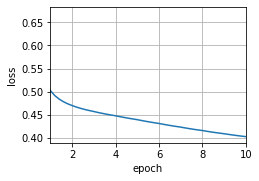

In [99]:
lr, num_epochs = 0.002, 10
train(net, data_iter, lr, num_epochs)

In [125]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) * 
                                     torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:
        print(f'与{query_token}相似的词为:{vocab.to_tokens(i)},\n cosine相似度={float(cos[i]):.3f}\n')
get_similar_tokens('吃饭', 10, net[1])

与吃饭相似的词为:三四个,
 cosine相似度=0.568

与吃饭相似的词为:沏,
 cosine相似度=0.531

与吃饭相似的词为:粥,
 cosine相似度=0.527

与吃饭相似的词为:回过,
 cosine相似度=0.525

与吃饭相似的词为:殷勤,
 cosine相似度=0.516

与吃饭相似的词为:罢,
 cosine相似度=0.511

与吃饭相似的词为:坐下,
 cosine相似度=0.505

与吃饭相似的词为:坐车,
 cosine相似度=0.504

与吃饭相似的词为:桌上,
 cosine相似度=0.500

与吃饭相似的词为:依言,
 cosine相似度=0.499

